In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from typing import Optional, Union
import NSR_identifier as nsr
import warnings
import multiprocessing
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import time
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
PF_SENSITIVITY_PATH = "../../sensitivity_all/"
FILE_NAMES = os.listdir(PF_SENSITIVITY_PATH)
SENSOR_DEPTH = pd.read_csv("../../../data/NEON_soil_moisture/swc_depthsV2.csv") # NEON sensor depth dataset
KSAT = pd.read_csv("../../NEON soil properties/rosetta_new_model_updates.csv")
EXCLUDED_SITES = ["BONA", "DEJU", "HEAL", "TOOL", "BARR", "KONA"]

In [3]:
def get_sensor_depth(site:str, hposition:str, vposition:str, 
                     time:Union[pd.Series, pd.Timestamp, None]) -> Union[float, int, pd.DataFrame]:
    """get sensor depth information.

    Args:
        site (str): NEON site.
        hposition (str): soil plot number. e.g., "001" - "005
        vposition (str): sensor position. e.g., "501" etc

    Returns:
        Union[float, int, pd.DataFrame]: sensor depth. Use none type while the sensor is not moving around.
    """
    
    sensor_depth = SENSOR_DEPTH.copy()
    sensor_depth = sensor_depth.rename(columns={"horizontalPosition.HOR":"hPosition",
                                                "verticalPosition.VER":"vPosition"})
    
    sensor_depth["startDateTime"] = pd.to_datetime(sensor_depth["startDateTime"], format="%Y-%m-%dT%H:%M:%SZ")
    sensor_depth["endDateTime"] = pd.to_datetime(sensor_depth["endDateTime"], format="%Y-%m-%dT%H:%M:%SZ")
    # convert the hoizontal position and vertical position field to strings 
    # sensor depth was stored in m, here converts to cm. 
    sensor_depth["sensorDepth"] = np.abs(sensor_depth["sensorDepth"]) * 100
    sensor_depth["hPosition"] = sensor_depth["hPosition"].apply(lambda x: f"00{x}")
    sensor_depth["vPosition"] = sensor_depth["vPosition"].apply(str) 
    
    candidate_depth = sensor_depth[(sensor_depth["siteID"] == site) &
                                   (sensor_depth["hPosition"] == hposition) &
                                   (sensor_depth["vPosition"] == vposition)].copy()
    # don't apply series at all 
    
    def nest_loop(r, data):
        for _, row in data.iterrows():
            if row["startDateTime"] <= r < row["endDateTime"]:
                return row["sensorDepth"]
                
            if row["startDateTime"] <= r and pd.isna(row["endDateTime"]):
                return row["sensorDepth"]
            
        return np.nan
    
    # if specify None meaning the values can be nan
    if time is None:
        assert candidate_depth.shape[0] == 1, "the sensor has multiple depth."
        return candidate_depth["sensorDepth"].values[0]
    elif isinstance(time, pd.Timestamp):
        return nest_loop(time, candidate_depth)
    elif isinstance(time, pd.Series):
        return time.apply(nest_loop, args=(candidate_depth, ))
    else:
        raise TypeError("input type is not accepted")

In [4]:
def separate_pits(site):
    data = KSAT.loc[KSAT["siteid"] == site].copy()
    megapit_df = data[data['pittype'] == 'Megapit'].copy()
    distributedpit_df = data[data['pittype'] == 'Distributed'].copy()
    megapit_data = {'megapit': megapit_df}
    distributedpit_data = {}
    unique_dispit_values = distributedpit_df['plotid'].unique()
    for b_val in unique_dispit_values:
        if pd.notna(b_val):  # Check if B value is not NaN
            distributedpit_data[b_val] = distributedpit_df[distributedpit_df['plotid'] == b_val]
    return {**megapit_data, **distributedpit_data}

In [5]:
def weight_ksat_by_depth(data, sensor_depth, discard_out_of_scope):
    """
    Calculate weighted average of ksat values based on sensor depth and soil horizon depths.
    
    Args:
        data: DataFrame containing soil horizon data with columns 'hzndept', 'hzndepb', and 'ksat_T'
        sensor_depth: Depth of the sensor (positive value)
        discard_out_of_scope: If True, return NaN when sensor is deeper than all horizons
    
    Returns:
        Weighted average of ksat values or NaN if conditions aren't met
    """
    # Make a sorted copy of the data
    df = data.sort_values(by="hzndepb").reset_index(drop=True).copy()
    
    # Check if horizons are continuous (each bottom matches next top)
    is_continuous = all(df["hzndepb"].iloc[:-1].values == df["hzndept"].iloc[1:].values)
    
    # Handle case where sensor is deeper than all horizons
    max_depth = df["hzndepb"].max()
    if sensor_depth > max_depth:
        if discard_out_of_scope:
            return np.nan
        sensor_depth = max_depth  # Adjust to use maximum available depth
    
    if not is_continuous:
        return np.nan
    
    # Calculate thickness and initialize weights
    df["thickness"] = df["hzndepb"] - df["hzndept"]
    df["weight"] = 0.0
    
    # Determine full and partial contributions
    full_mask = (sensor_depth >= df['hzndepb'])
    partial_mask =(~full_mask) & (df['hzndept'] < sensor_depth) & (sensor_depth < df['hzndepb'])
    
    # Calculate weights
    df.loc[full_mask, 'weight'] = df.loc[full_mask, 'thickness'] / sensor_depth
    df.loc[partial_mask, 'weight'] = (sensor_depth - df.loc[partial_mask, 'hzndept']) / sensor_depth

    # Calculate weighted ksat
    weighted_ksat = (df["ksat_T"] * df["weight"]).sum()
    return weighted_ksat

In [6]:
def ksat_weight_selection_method(site, sensor_depth, discard_out_of_scope, log_it = True, selection_method = "max"):
    # Note the MEAN here!
    data_hub = separate_pits(site)
    ksat_hub = list(data_hub.keys())
    candidate_ksat = []
    for i in ksat_hub:
        data = data_hub[i]
        ksat = weight_ksat_by_depth(data, sensor_depth, discard_out_of_scope)
        if log_it:
            ksat = np.log(ksat)
        candidate_ksat.append(ksat)
    candidate_ksat = np.array(candidate_ksat)
    candidate_ksat = np.where(np.isinf(candidate_ksat), np.nan, candidate_ksat)
    if selection_method == "min":
        return np.nanmin(candidate_ksat)
    if selection_method == "mean":
        return np.nanmean(candidate_ksat) 
    return np.nanmax(candidate_ksat)

In [7]:
def calculate_time_difference(sm_onset, precip_onset):
    day_in_seconds = 24 * 60 * 60
    return (pd.to_datetime(sm_onset) - pd.to_datetime(precip_onset)).total_seconds() / day_in_seconds

In [8]:
def identify_velocity(row, velocity):
    """Helper function to identify preferential flow based

    Args:
        row (pandas.Series): first arg of apply function.
        velocity (list): list of column names.

    Returns:
        bool: if pf is identified. True --> yest, False --> No.
    """
    pf_v = False
    series1 = row.loc[velocity].copy().reset_index()
    series1.columns = ['New_Index', 'Value']
    if series1["Value"].any():
        pf_v = True
    return pf_v

In [9]:
def get_pf_classification(f):
    extracted_var = ["stormSum", "stormPeakIntensity", "stormDuration", "flowTypes"]
    min_sep_thresh = [2, 6, 12, 24]  
    site, _, precip_param, sm_param = f.split("_")
    min_sep = precip_param.split("sep")[-1].split("h")[0]
    sm_threshold = sm_param.split("sm")[0]
    micro_loc = sm_param.split("sm")[1].split(".csv")[0]
    if int(min_sep) in min_sep_thresh: 
        data = pd.read_csv(PF_SENSITIVITY_PATH + f)
        time_col = [i for i in data.columns if "Time" in i]
        for col in time_col:
                data[col] = data[col].apply(pd.to_datetime)
        ns_analysis = nsr.non_sequential_detection(data)
        ns_analysis["stormStartTime"] = ns_analysis["stormStartTime"].apply(pd.to_datetime)
        num_sensors = len([i for i in data.columns if "smOnsetTime_" in i])
        
        for i in np.arange(1, num_sensors + 1):
            sensor_id = f"50{i}"
            # velocity_metrics = [f"num_velocity_{sensor_id}_median", f"num_velocity_{sensor_id}_95th",
            #                     f"num_velocity_{sensor_id}_99th", f"num_velocity_name_{sensor_id}"]
            # velocity_metrics = [f"num_velocity_{sensor_id}_median", f"num_velocity_{sensor_id}_95th",
            #                     f"num_velocity_{sensor_id}_99th", f"num_velocity_name_{sensor_id}"]
            if site == "OAES":
                ns_analysis = ns_analysis[(ns_analysis["stormStartTime"] < pd.to_datetime("2019-12-07 00:00:00")) |
                                        (ns_analysis["stormStartTime"] >= pd.to_datetime("2021-03-12 00:00:00"))] .copy()
            
            time_difference = ns_analysis.apply(lambda x: calculate_time_difference(x[f"smOnsetTime_{sensor_id}"],
                                                            x["stormStartTime"]), axis = 1)
            ns_analysis[f"smOnsetTime_{sensor_id}"] =  pd.to_datetime(ns_analysis[f"smOnsetTime_{sensor_id}"])
            ns_analysis[f"sensor_depth_{sensor_id}"] = get_sensor_depth(site, hposition=micro_loc, vposition=sensor_id, time = ns_analysis["stormStartTime"])
            ns_analysis[f"velocity_{sensor_id}"] = np.log(ns_analysis[f"sensor_depth_{sensor_id}"]/time_difference)
            ns_analysis[f"velocity_{sensor_id}"] = ns_analysis[f"velocity_{sensor_id}"].replace([np.inf, -np.inf], np.nan)
            # ns_analysis[velocity_metrics]  =  ns_analysis.apply(lambda x: get_numerical_velocity(x[f"sensor_depth_{sensor_id}"],
            #                                             site), axis = 1, result_type="expand")
            ns_analysis[f"ksat_{sensor_id}"] = ns_analysis.apply(lambda x: ksat_weight_selection_method(site, x[f"sensor_depth_{sensor_id}"], 
                                                                                                discard_out_of_scope=True, 
                                                                                                log_it = True, selection_method="max"),
                                                                                                axis=1, result_type="expand")
            ns_analysis[f"pf_v_{sensor_id}"] = (ns_analysis[f"velocity_{sensor_id}"] > ns_analysis[f"ksat_{sensor_id}"])
        ns_analysis["pf_v"] = ns_analysis.apply(identify_velocity, args=([f"pf_v_50{i}" for i in np.arange(1, num_sensors + 1)],), axis = 1)
        ns_analysis["site"] = site
        ns_analysis["min_sep"] = int(min_sep)
        ns_analysis["sm_threshold"] = float(sm_threshold)
        ns_analysis[["site"] + extracted_var + ["min_sep", "sm_threshold", "pf_v"]].to_csv(f"../../sensitivity_results_beta/{f[:-4]}_sens_results.csv", index =False)
        print(f"finished working on {f}")
        return ns_analysis[["site"] + extracted_var + ["min_sep", "sm_threshold", "pf_v"]]

In [10]:
# Parallel file processing implementation
def process_single_file(filename):
    """Worker function to process a single file"""
    try:
        if filename.split("_")[0] in EXCLUDED_SITES:
            return None
        
        if os.path.exists('../../sensitivity_results_beta/' + filename[:-4] + "_sens_results.csv"):
            temp_data = pd.read_csv('../../sensitivity_results_beta/' + filename[:-4] + "_sens_results.csv")
            print(f"loaded {filename[:-4]}")
        else:
            print(f"running here the local func {filename[:-4]}")
            temp_data = get_pf_classification(filename)
        return temp_data
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

# Configuration
USE_PARALLEL = True  # Set to False for sequential processing
MAX_WORKERS = multiprocessing.cpu_count() - 4  # Limit to 4 workers to avoid overwhelming

# Filter out excluded sites first
valid_files = [f for f in FILE_NAMES if f.split("_")[0] not in EXCLUDED_SITES]

if USE_PARALLEL:
    print(f"Processing {len(valid_files)} files using {MAX_WORKERS} parallel workers...")
    start_time = time.time()
    
    # Use ThreadPoolExecutor which works better in Jupyter notebooks
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        results = list(executor.map(process_single_file, valid_files))
    
    # Filter out None results and concatenate
    item = [result for result in results if result is not None]
    
    if item:
        FINAL_DATA = pd.concat(item, ignore_index=True)
        print(f"Successfully processed {len(item)} files")
    else:
        FINAL_DATA = pd.DataFrame()
    
    end_time = time.time()
    print(f"Parallel processing completed in {end_time - start_time:.2f} seconds")

Processing 3200 files using 20 parallel workers...
running here the local func ABBY_min_sep12h_0.001sm001
running here the local func ABBY_min_sep12h_0.001sm002
running here the local func ABBY_min_sep12h_0.001sm003
running here the local func ABBY_min_sep12h_0.001sm004
running here the local func ABBY_min_sep12h_0.001sm005
running here the local func ABBY_min_sep12h_0.01sm001
running here the local func ABBY_min_sep12h_0.01sm002
running here the local func ABBY_min_sep12h_0.01sm003
running here the local func ABBY_min_sep12h_0.01sm004
running here the local func ABBY_min_sep12h_0.01sm005
running here the local func ABBY_min_sep12h_0.05sm002
running here the local func ABBY_min_sep12h_0.05sm001
running here the local func ABBY_min_sep12h_0.05sm003
running here the local func ABBY_min_sep12h_0.05sm004
running here the local func ABBY_min_sep12h_0.05sm005
running here the local func ABBY_min_sep12h_0.1sm001
running here the local func ABBY_min_sep12h_0.1sm003
running here the local func 

C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)
C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)


finished working on MLBS_min_sep12h_0.1sm001.csv
running here the local func MLBS_min_sep24h_0.1sm004


C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)


finished working on MLBS_min_sep24h_0.001sm004.csv
running here the local func MLBS_min_sep24h_0.1sm005
finished working on MLBS_min_sep12h_0.1sm003.csv
running here the local func MLBS_min_sep2h_0.001sm001
finished working on MLBS_min_sep24h_0.001sm005.csv
running here the local func MLBS_min_sep2h_0.001sm002
finished working on MLBS_min_sep24h_0.001sm001.csv
running here the local func MLBS_min_sep2h_0.001sm003


C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)


finished working on MLBS_min_sep24h_0.001sm002.csv
running here the local func MLBS_min_sep2h_0.001sm004


C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)


finished working on MLBS_min_sep24h_0.001sm003.csv
running here the local func MLBS_min_sep2h_0.001sm005
finished working on MLBS_min_sep24h_0.01sm004.csv
running here the local func MLBS_min_sep2h_0.01sm001
finished working on MLBS_min_sep24h_0.01sm005.csv
running here the local func MLBS_min_sep2h_0.01sm002


C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)


finished working on MLBS_min_sep24h_0.05sm004.csv
running here the local func MLBS_min_sep2h_0.01sm003
finished working on MLBS_min_sep24h_0.01sm001.csv
running here the local func MLBS_min_sep2h_0.01sm004
finished working on MLBS_min_sep24h_0.01sm002.csv
running here the local func MLBS_min_sep2h_0.01sm005


C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:18: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(candidate_ksat)
C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)


finished working on MLBS_min_sep24h_0.05sm005.csv
running here the local func MLBS_min_sep2h_0.05sm001
finished working on MLBS_min_sep24h_0.05sm002.csv
running here the local func MLBS_min_sep2h_0.05sm002
finished working on MLBS_min_sep24h_0.01sm003.csv
running here the local func MLBS_min_sep2h_0.05sm003
finished working on MLBS_min_sep24h_0.05sm001.csv
running here the local func MLBS_min_sep2h_0.05sm004
finished working on MLBS_min_sep24h_0.05sm003.csv
running here the local func MLBS_min_sep2h_0.05sm005
finished working on MLBS_min_sep24h_0.1sm004.csv
running here the local func MLBS_min_sep2h_0.1sm001
finished working on MLBS_min_sep24h_0.1sm002.csv
running here the local func MLBS_min_sep2h_0.1sm002


C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)


finished working on MLBS_min_sep24h_0.1sm001.csv
running here the local func MLBS_min_sep2h_0.1sm003
finished working on MLBS_min_sep24h_0.1sm005.csv
running here the local func MLBS_min_sep2h_0.1sm004


C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)


finished working on MLBS_min_sep24h_0.1sm003.csv
running here the local func MLBS_min_sep2h_0.1sm005


C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)
C:\Users\libon.ONID\AppData\Local\Temp\ipykernel_4128\963274744.py:10: RuntimeWarning: divide by zero encountered in log
  ksat = np.log(ksat)


finished working on MLBS_min_sep2h_0.001sm004.csv
running here the local func MLBS_min_sep6h_0.001sm001
finished working on MLBS_min_sep2h_0.001sm005.csv
running here the local func MLBS_min_sep6h_0.001sm002
finished working on MLBS_min_sep2h_0.01sm004.csv
running here the local func MLBS_min_sep6h_0.001sm003
finished working on MLBS_min_sep2h_0.01sm005.csv
running here the local func MLBS_min_sep6h_0.001sm004
finished working on MLBS_min_sep2h_0.05sm005.csv
running here the local func MLBS_min_sep6h_0.001sm005
finished working on MLBS_min_sep2h_0.05sm004.csv
running here the local func MLBS_min_sep6h_0.01sm001
finished working on MLBS_min_sep2h_0.001sm002.csv
running here the local func MLBS_min_sep6h_0.01sm002
finished working on MLBS_min_sep2h_0.001sm001.csv
running here the local func MLBS_min_sep6h_0.01sm003
finished working on MLBS_min_sep2h_0.1sm004.csv
running here the local func MLBS_min_sep6h_0.01sm004
finished working on MLBS_min_sep2h_0.01sm002.csv
running here the local fu

In [14]:
def stats_producer(final_data):
    total_flow = final_data[(final_data["pf_v"]) | (final_data["flowTypes"] == "nonSequentialFlow")].copy()
    velocity = final_data[(final_data["pf_v"])].copy()
    nsr_only = final_data[ (final_data["flowTypes"] == "nonSequentialFlow")].copy()
    unique_sm_thresholds = sorted(final_data["sm_threshold"].unique())
    unique_precip_sep = sorted(final_data["min_sep"].unique())
    stats = []
    for p_sum in np.arange(1,11):
        for p_sep in unique_precip_sep:
            for sm_s in unique_sm_thresholds:
                total_pf_left = total_flow[(total_flow["sm_threshold"] == sm_s) & (total_flow["min_sep"] == p_sep) & (total_flow["stormSum"] >= p_sum)].copy()
                velocity_left = velocity[(velocity["sm_threshold"] == sm_s) & (velocity["min_sep"] == p_sep) & (velocity["stormSum"] >= p_sum)]
                nsr_left = nsr_only[(nsr_only["sm_threshold"] == sm_s) & (nsr_only["min_sep"] == p_sep) & (nsr_only["stormSum"] >= p_sum)].copy()
                stats.append([p_sum, p_sep, sm_s,
                            total_pf_left.shape[0], 
                            velocity_left.shape[0],
                            nsr_left.shape[0]])
    stats_hub = pd.DataFrame(stats, columns = ["sumP", "sepP", "smThreshold", "totalNumPF", "VPF","NSRPF"])
    return stats_hub

In [15]:
stats_hub = stats_producer(FINAL_DATA)

c:\Users\libon.ONID\AppData\Local\anaconda3\envs\NEON_PF_dev\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\libon.ONID\AppData\Local\anaconda3\envs\NEON_PF_dev\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\libon.ONID\AppData\Local\anaconda3\envs\NEON_PF_dev\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\libon.ONID\AppData\Local\anaconda3\envs\NEON_PF_dev\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_c

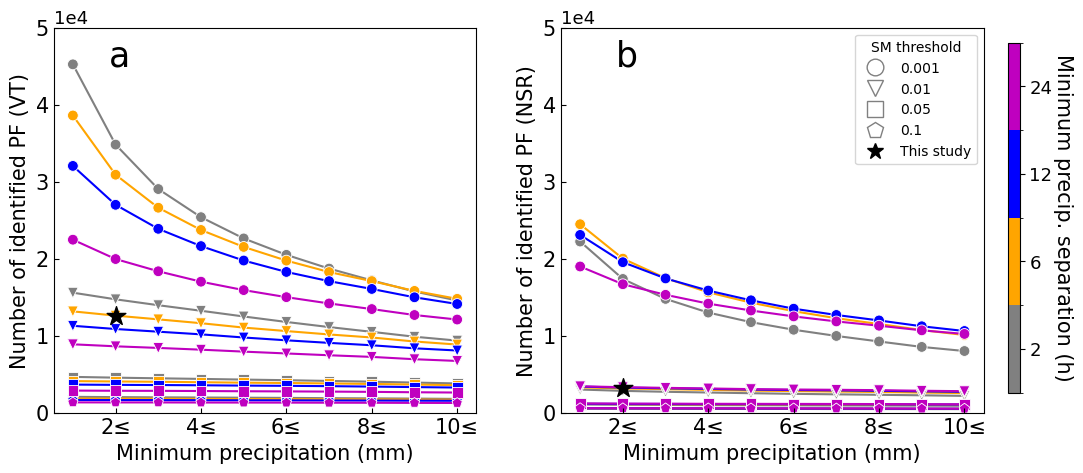

In [16]:
import matplotlib.pyplot as plt
import numpy as np
# Create a scatter plot with bubbles
def get_types(stats_hub):
    FIANL_PARAMS = stats_hub[
                            (stats_hub["sepP"] == 6) &
                            (stats_hub["sumP"] == 2) &
                            (stats_hub["smThreshold"] == 0.01)
                             ]
    from matplotlib.colors import BoundaryNorm
    from matplotlib.colorbar import ColorbarBase
    import matplotlib.lines as mlines
    

    marker_styles = ['o', 'v', 's', 'p']
    
    # Define discrete color values and labels
    colors = ['grey', 'orange', 'blue', 'm']
    labels = ['2', '6', '12', '24']
    handle_labels = stats_hub["smThreshold"].unique()

    # Create a custom color palette
    palette = {value: color for value, color in zip(stats_hub['sepP'].unique(), colors)}
    marker = {value: mk for value, mk in zip(stats_hub["smThreshold"].unique(), marker_styles)}
    
    
    # Create a figure and axis
    fig, ax = plt.subplots(1,2, figsize = (12,5))
    names = [ "VPF","NSRPF"]
    labels_y = [
              "Number of identified PF (VT)",
              "Number of identified PF (NSR)"]
    fig_num = ["a", "b"]
    xticklabels = ["2≤", "4≤",  "6≤", "8≤",  "10≤"]
    xticks = [2, 4, 6, 8, 10]
    # Create the scatter plot with the custom palette
    from matplotlib.lines import Line2D
    threshold = stats_hub[(stats_hub["sepP"] ==6) & (stats_hub["sumP"] ==2) & (stats_hub["smThreshold"] ==0.01)]
    for i in range(len(names)):
        current_data=  stats_hub[["sumP", "sepP", "smThreshold", names[i]]]
        sns.scatterplot(data=stats_hub, x="sumP", y=names[i], hue="sepP", style="smThreshold",
                    palette=palette, markers=marker, ax=ax[i], legend=False, s=60)
    
        ax[i].set_ylim(0, 50000)
        ax[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax[i].yaxis.get_offset_text().set_size(13)
        legend_elements = []
        for l in range(len(handle_labels)):
        
            legend_elements.append(
                Line2D([], [], marker=marker_styles[l], markeredgecolor='grey', label=handle_labels[l],
                    markerfacecolor='none', markersize=12, linestyle="none"))
            
            data = current_data[current_data["smThreshold"] == handle_labels[l]]

            for key, val in palette.items():
                sep_data = data[data["sepP"] == key]
                ax[i].plot(sep_data["sumP"], sep_data[names[i]], c=val, zorder=0)
        
        legend_elements.append(
            Line2D([], [], marker="*", markeredgecolor='black', label="This study",
                markerfacecolor='black', markersize=12, linestyle="none"))

        ax[i].scatter(threshold["sumP"], threshold[names[i]], marker="*", s=200, zorder=200, c="black")
        ax[i].set_xlabel("Minimum precipitation (mm)", fontsize = 15)
        # ax.set_ylabel(ylabel, fontsize = 15)
        ax[i].tick_params("both", labelsize =15, direction = "in")
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels(xticklabels)
        ax[i].set_ylabel(labels_y[i],fontsize = 15)
        ax[i].text(0.13, 0.9, fig_num[i],
            transform = ax[i].transAxes, fontsize= 25)
    ax[-1].legend(handles=legend_elements, loc='upper right')

    # Create a discrete colorbar
    
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    cmap = plt.cm.colors.ListedColormap(colors)
    norm = BoundaryNorm(np.arange(len(labels) + 1), cmap.N)
    colorbar = ColorbarBase(cax, cmap=cmap, norm=norm, ticks=np.arange(len(labels)) + 0.5)
    colorbar.set_ticklabels(labels)
    colorbar.ax.set_ylabel("Minimum precip. separation (h)", rotation=270, labelpad =15, fontsize = 15)
    colorbar.ax.tick_params("y", labelsize = 13)
    ax[-1].legend(handles=legend_elements, loc='upper right', title = "SM threshold")
   
get_types(stats_hub)